## import 

In [12]:
!python -m pip install polars

/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/pty.py:89: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  pid, fd = os.forkpty()


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import scipy.stats as stats
import polars as pl

In [14]:
# calc lowerbound based on sampled sentences
grammar_names = [
    "Base",
    "DeterministicShuffle",
    "NonDeterministicShuffle",
    "LocalShuffle",
    "EvenOddShuffle",
    "NoReverse",
    "PartialReverse",
    "FullReverse",
]
results_dir = Path("../results").resolve()
dataset_dir = Path("../data/fairseq_train/eos_zipf_min1_max_20_10M").resolve()
total_count = 100_000_000
lower_bound_complexity = []
for grammar_name in grammar_names:
    counts_file = (
        results_dir
        / "length_sampling"
        / f"100M_samples_eos_zipf_min1_max20{'_' + grammar_name if grammar_name != 'Base' else ''}"
        / "sample_counts.csv.gz"
    )
    # polarsで読んで、count / total_countで確率を計算
    counts_df = pl.read_csv(counts_file, new_columns=["sentence", "count"])
    counts_df = counts_df.with_columns(
        (pl.col("count") / total_count).alias("probability")
    )

    sentences_in_data = []
    split_file = dataset_dir / grammar_name / f"test.txt"
    with open(split_file, "r") as f:
        sentences_in_data.extend([line.strip() + " [eos]" for line in f.readlines()])
    print("Length of sentences in data:", len(sentences_in_data))

    sentences_in_data = pl.DataFrame({"sentence": sentences_in_data})
    sentences_in_data = sentences_in_data.join(counts_df, on="sentence", how="left")
    assert sentences_in_data["probability"].null_count() == 0

    # lower boundを計算
    entropy = stats.entropy(sentences_in_data["probability"].to_numpy(), base=2)
    perplexity = 2**entropy
    lower_bound_complexity.append(
        {
            "grammar_name": grammar_name,
            "lower_bound_entropy": entropy,
            "lower_bound_perplexity": perplexity,
        }
    )

Length of sentences in data: 1000000
Length of sentences in data: 1000000
Length of sentences in data: 1000000
Length of sentences in data: 1000000
Length of sentences in data: 1000000
Length of sentences in data: 1000000
Length of sentences in data: 1000000
Length of sentences in data: 1000000


In [28]:
lower_bound_complexity

[{'grammar_name': 'Base',
  'lower_bound_entropy': 14.517575020161082,
  'lower_bound_perplexity': 23454.465772243035},
 {'grammar_name': 'DeterministicShuffle',
  'lower_bound_entropy': 14.517575020161082,
  'lower_bound_perplexity': 23454.465772243035},
 {'grammar_name': 'NonDeterministicShuffle',
  'lower_bound_entropy': 14.370460679417368,
  'lower_bound_perplexity': 21180.671080511154},
 {'grammar_name': 'LocalShuffle',
  'lower_bound_entropy': 14.517575020161082,
  'lower_bound_perplexity': 23454.465772243035},
 {'grammar_name': 'EvenOddShuffle',
  'lower_bound_entropy': 14.517575020161082,
  'lower_bound_perplexity': 23454.465772243035},
 {'grammar_name': 'NoReverse',
  'lower_bound_entropy': 14.512459474307198,
  'lower_bound_perplexity': 23371.44758435123},
 {'grammar_name': 'PartialReverse',
  'lower_bound_entropy': 14.512451116613647,
  'lower_bound_perplexity': 23371.312191336474},
 {'grammar_name': 'FullReverse',
  'lower_bound_entropy': 14.512187722762738,
  'lower_bound_

In [39]:
sentences_in_data.get_column('count').value_counts(name='value',sort=True)

count,value
i64,u32
1,842244
2,21152
3,10823
4,6972
5,5421
…,…
861,2
730,2
766,2


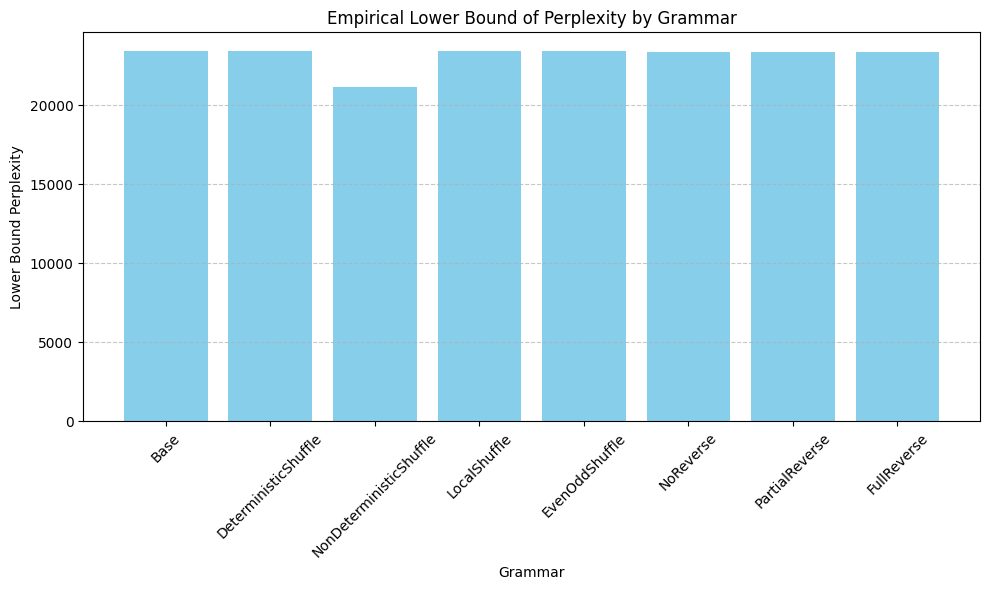

In [40]:
# 理論下限のプロット
fig, ax = plt.subplots(figsize=(10, 6))

# DataFrameに変換して扱いやすくする
lower_bound_df = pd.DataFrame(lower_bound_complexity)

# プロット
ax.bar(
    lower_bound_df['grammar_name'],
    lower_bound_df['lower_bound_perplexity'],
    color='skyblue'
)

# 見やすさの調整
ax.set_xticks(range(len(grammar_names)))
ax.set_xticklabels(grammar_names, rotation=45)
ax.set_xlabel('Grammar')
ax.set_ylabel('Lower Bound Perplexity')
ax.set_title('Empirical Lower Bound of Perplexity by Grammar')

# Y軸を対数スケールに（値の範囲が大きいため）
# ax.set_yscale('log')

# グリッドと余白の調整
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [18]:
grammar_names = [
    "Base",
    "DeterministicShuffle",
    "NonDeterministicShuffle",
    "LocalShuffle",
    "EvenOddShuffle",
    "NoReverse",
    "PartialReverse",
    "FullReverse",
]
num_seeds = 3
model_names = ["transformer"]
results_dir = Path("../results").resolve()

result_list = []
for grammar_name in grammar_names:
    for model_name in model_names:
        model_result_dir = results_dir / f"{model_name}_results"
        grammar_result_dir = model_result_dir / f"{grammar_name}_10M"

        # 各シードごとの統計量を保存
        seed_stats = []
        for seed_i in range(num_seeds):
            split_result_file = grammar_result_dir / f"seed{seed_i}" / "test.scores.txt"
            with open(split_result_file) as f:
                scores = [float(line.strip()) for line in f]
            probs = [np.exp(score) for score in scores]
            entropy = stats.entropy(probs, base=2)
            perplexity = 2**entropy
            seed_stats.append({"entropy": entropy, "perplexity": perplexity})

        # 平均と標準偏差を計算
        entropies = [s["entropy"] for s in seed_stats]
        perplexities = [s["perplexity"] for s in seed_stats]

        result_list.append(
            {
                "model_name": model_name,
                "grammar_name": grammar_name,
                "entropy_mean": np.mean(entropies),
                "entropy_std": np.std(entropies),
                "perplexity_mean": np.mean(perplexities),
                "perplexity_std": np.std(perplexities),
            }
        )

In [19]:
result_df = pd.DataFrame(result_list).sort_values(["model_name", "grammar_name"])
result_df

,model_name,grammar_name,entropy_mean,entropy_std,perplexity_mean,perplexity_std
0,transformer,Base,13.692404,0.016001,13238.869385,146.399318
1,transformer,DeterministicShuffle,14.291385,0.023340,20053.598268,322.824811
4,transformer,EvenOddShuffle,13.979628,0.040770,16160.687682,453.530044
7,transformer,FullReverse,12.553729,0.032605,6013.959253,136.892158
3,transformer,LocalShuffle,14.394497,0.020532,21538.701484,307.633008
5,transformer,NoReverse,14.057987,0.020839,17057.719461,245.887561
2,transformer,NonDeterministicShuffle,11.916051,0.007568,3864.511574,20.298190
6,transformer,PartialReverse,13.998184,0.015299,16364.306420,172.987407


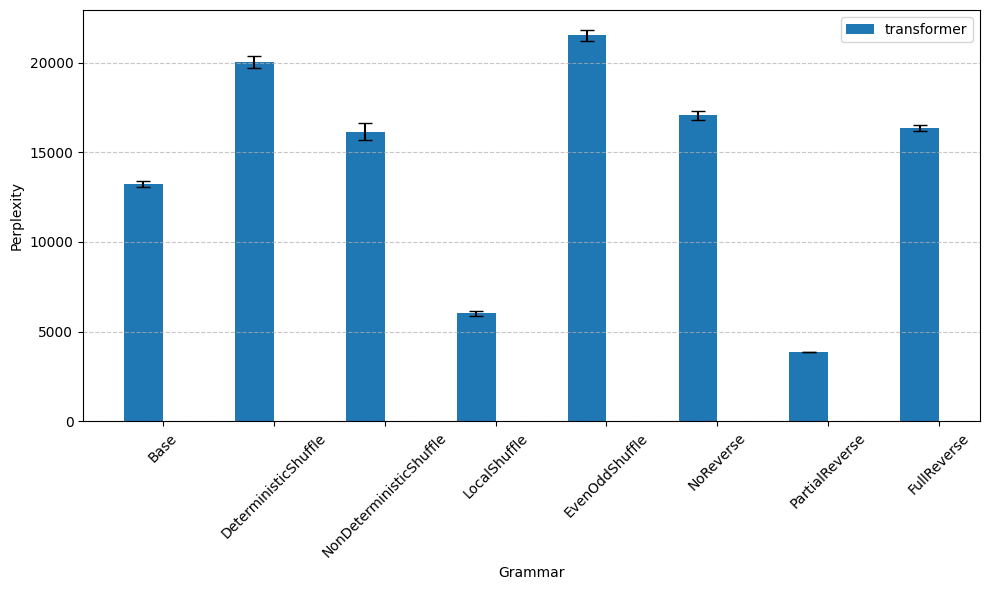

In [20]:
# plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35

for i, model_name in enumerate(model_names):
    model_results = result_df[result_df["model_name"] == model_name]
    ax.bar(
        np.arange(len(grammar_names)) + i * bar_width,
        model_results["perplexity_mean"],
        bar_width,
        label=model_name,
        yerr=model_results["perplexity_std"],
        capsize=5,
    )

ax.set_xticks(np.arange(len(grammar_names)) + bar_width / 2)
ax.set_xticklabels(grammar_names, rotation=45)
ax.set_xlabel("Grammar")
ax.set_ylabel("Perplexity")
ax.legend()

# グラフを見やすくする追加設定
plt.tight_layout()  # テキストの重なりを防ぐ
plt.grid(axis='y', linestyle='--', alpha=0.7)  # y軸のグリッドを追加

plt.show()

In [48]:
lower_bound_df = pd.DataFrame(lower_bound_complexity)
result_df = result_df.merge(lower_bound_df, on='grammar_name')

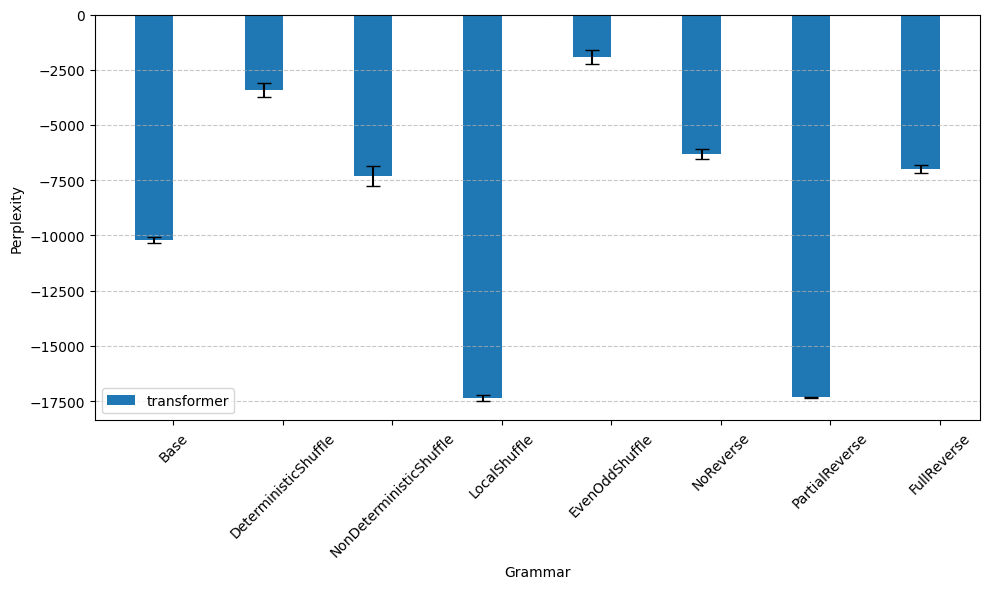

In [49]:
# plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35

for i, model_name in enumerate(model_names):
    model_results = result_df[result_df["model_name"] == model_name]
    ax.bar(
        np.arange(len(grammar_names)) + i * bar_width,
        model_results["perplexity_mean"] - model_results['lower_bound_perplexity'],
        bar_width,
        label=model_name,
        yerr=model_results["perplexity_std"],
        capsize=5,
    )

ax.set_xticks(np.arange(len(grammar_names)) + bar_width / 2)
ax.set_xticklabels(grammar_names, rotation=45)
ax.set_xlabel("Grammar")
ax.set_ylabel("Perplexity")
ax.legend()

# グラフを見やすくする追加設定
plt.tight_layout()  # テキストの重なりを防ぐ
plt.grid(axis='y', linestyle='--', alpha=0.7)  # y軸のグリッドを追加

plt.show()